In [1]:
from datetime import datetime
from lassort import load, localAssortF
import networkx as nx
import numpy as np
import pandas as pd

from networkx.generators.community import stochastic_block_model as sbm
from networkx.algorithms.community import modularity
from matplotlib import pyplot as plt

# Problem Statement
It looks like the multiscale mixing algorithm tends to classify larger classes as having more extreme scores and smaller classes as having more average scores given equal probability of connecting in the SBM.  I believe this is due to the fact that the algorithm looks at the difference between the local and global scores rather than the ratio.  Smaller classes are more likely to have more connections to other classes given the same pairing probability in the mixing matrix.  

This seems to be analogous to the fact that modularity scores favor larger communities over smaller ones.  Since multiscale mixing is a generalization of modularity, it produces higher (or lower for disassortative) scores for larger groups.

TODO: Find sources discussing the limitations of modularity.

For an SBM model with 2 communities and fixed mixing matrix, identify the multiscale mixing score for vertices within each community, and the number of edges within and between communities, and the modularity of the network.  How do these parameters vary as a function of community size?  How do they vary as a function of the mixing matrix?

# Future Thoughts
Generalize the resolution parameter from modularity to work with multiscale mixing.  Look at https://link.aps.org/accepted/10.1103/PhysRevE.94.052315 .

Can you generalize Equations 13-15 to work in the case where each partition has a distinct omega_rs?  I think you can just stick the appropriate gamma value into equation 6 of the multiscale mixing paper.

In [144]:
N = 800
p = [[.1,.05], [.05, .1]]

def run_analysis(
    s0, 
    N=N, 
    p=p):
    sizes = [s0, N - s0]
    G = sbm(sizes, p)
    E = nx.convert_matrix.to_pandas_edgelist(G).values
    M = np.hstack([np.zeros(sizes[0]), np.ones(sizes[1])])

    assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

    # average score for first group
    T0 = assortT[:sizes[0]].mean()
    # average score for second group
    T1 = assortT[sizes[0]:].mean()

    # mixing score vs. group
    r = np.corrcoef(assortT, M)[0,1]

    # modularity of partition
    A = nx.convert_matrix.to_scipy_sparse_matrix(G)

    # this is the stub count, or the edge count times 2
    m2 = A.sum()

    # intra-community edge density for each group
    e0 = A[:sizes[0], :sizes[0]].sum() / m2
    e1 = A[sizes[0]:, sizes[0]:].sum() / m2

    # degree proportion for each group
    a0 = A[:sizes[0],:].sum() / m2
    a1 = A[sizes[0]:,:].sum() / m2

    # modularity score
    Q = e0 -a0**2 + e1 - a1**2
    
    return (m2/2, e0, e1, a0, a1, Q, T0, T1)

In [145]:
m, e0, e1, a0, a1, Q, T0, T1 = run_analysis(400)

In [158]:
s0s = pd.Series(np.arange(10, 401, 10))
results = s0s.apply(run_analysis)

In [167]:
columns = ["m", "e0", "e1", "a0", "a1", "Q", "T0", "T1"]
df = pd.DataFrame(
    results.to_list(),
    columns=columns
)
df["s0"] = s0s

df

,m,e0,e1,a0,a1,Q,T0,T1,s0
0,31648.0,0.000126,0.987456,0.006335,0.993665,0.000173,-38.836823,0.261904,10
1,31586.0,0.000950,0.974166,0.013392,0.986608,0.001541,-17.513126,0.297626,20
2,30863.0,0.001555,0.962447,0.019554,0.980446,0.002346,-11.799412,0.297844,30
3,30558.0,0.002749,0.946201,0.028274,0.971726,0.003899,-7.913212,0.303625,40
4,30073.0,0.004556,0.932863,0.035846,0.964154,0.006541,-5.987025,0.319884,50
5,29928.0,0.005914,0.920743,0.042586,0.957414,0.008201,-4.931631,0.325933,60
6,29288.0,0.008877,0.903715,0.052581,0.947419,0.012225,-3.790319,0.340612,70
7,29165.0,0.012069,0.888051,0.062009,0.937991,0.016448,-3.061583,0.353833,80
8,28779.0,0.014108,0.873310,0.070399,0.929601,0.018303,-2.632204,0.348937,90
9,28351.0,0.019329,0.856936,0.081196,0.918804,0.025473,-2.112897,0.372996,100


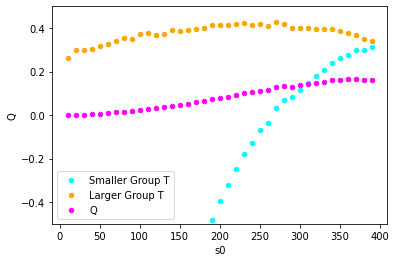

In [205]:
ax = df.plot(kind="scatter", x="s0", y="T0", color="cyan",ylim=[-0.5, 0.5])
df.plot(kind="scatter", x="s0", y="T1", ax=ax, color="orange")
df.plot(kind="scatter", x="s0", y="Q", ax=ax, color="magenta")
ax.legend(["Smaller Group T", "Larger Group T", "Q"])

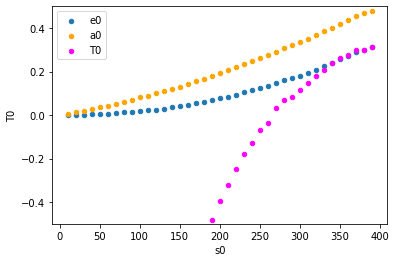

In [209]:
ax = df.plot(kind="scatter", x="s0", y="e0", ylim=[-0.5, 0.5])
df.plot(kind="scatter", x="s0", y="a0", ax=ax, color="orange")
df.plot(kind="scatter", x="s0", y="T0", ax=ax, color="magenta")
ax.legend(["e0", "a0", "T0"])

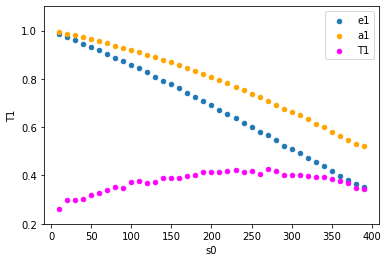

In [214]:
ax = df.plot(kind="scatter", x="s0", y="e1", ylim=[0.2, 1.1])
df.plot(kind="scatter", x="s0", y="a1", ax=ax, color="orange")
df.plot(kind="scatter", x="s0", y="T1", ax=ax, color="magenta")
ax.legend(["e1", "a1", "T1"])

Can we stick these together and get the whole range of group sizes?

In [236]:
df_rev = df.copy()
df_rev["s0"] = N - df_rev.s0

# switch T0, T1
# swiith a0, a1
# switch e0, e1
df_rev.columns = ['m', 'e1', 'e0', 'a1', 'a0', 'Q', 'T1', 'T0', 's0']

In [240]:
dff = pd.concat([df,df_rev], axis=0).sort_values("s0").reset_index(drop=True)
dff

,m,e0,e1,a0,a1,Q,T0,T1,s0
0,31648.0,0.000126,0.987456,0.006335,0.993665,0.000173,-38.836823,0.261904,10
1,31586.0,0.000950,0.974166,0.013392,0.986608,0.001541,-17.513126,0.297626,20
2,30863.0,0.001555,0.962447,0.019554,0.980446,0.002346,-11.799412,0.297844,30
3,30558.0,0.002749,0.946201,0.028274,0.971726,0.003899,-7.913212,0.303625,40
4,30073.0,0.004556,0.932863,0.035846,0.964154,0.006541,-5.987025,0.319884,50
...,...,...,...,...,...,...,...,...,...
73,30073.0,0.932863,0.004556,0.964154,0.035846,0.006541,0.319884,-5.987025,750
74,30558.0,0.946201,0.002749,0.971726,0.028274,0.003899,0.303625,-7.913212,760
75,30863.0,0.962447,0.001555,0.980446,0.019554,0.002346,0.297844,-11.799412,770
76,31586.0,0.974166,0.000950,0.986608,0.013392,0.001541,0.297626,-17.513126,780


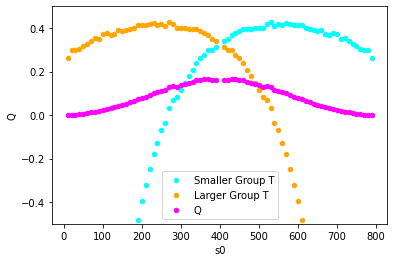

In [242]:
ax = dff.plot(kind="scatter", x="s0", y="T0", color="cyan",ylim=[-0.5, 0.5])
dff.plot(kind="scatter", x="s0", y="T1", ax=ax, color="orange")
dff.plot(kind="scatter", x="s0", y="Q", ax=ax, color="magenta")
ax.legend(["Smaller Group T", "Larger Group T", "Q"])

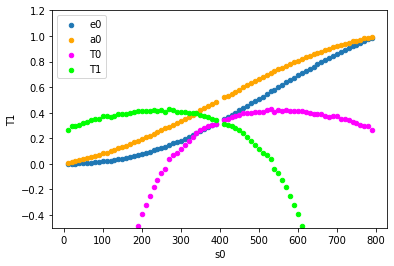

In [249]:
ax = dff.plot(kind="scatter", x="s0", y="e0", ylim=[-0.5, 1.2])
dff.plot(kind="scatter", x="s0", y="a0", ax=ax, color="orange")
dff.plot(kind="scatter", x="s0", y="T0", ax=ax, color="magenta")
dff.plot(kind="scatter", x="s0", y="T1", ax=ax, color="lime")
ax.legend(["e0", "a0", "T0", "T1"])

# Look at Gamma Values
Based on the Newman paper, we expect the optimal value weight to re-create the SBM to be

$$\gamma = \frac{\omega_{in} - \omega_{out}}{\log \omega_{in} - \log \omega_{out}}$$

where $\omega_{in}$ is the total probability of an arbitrary edge being an in-group edge and $\omega_{out}$ is the total probability of an arbitrary edge being a cross-group edge.  (TODO: how does this generalize when we are not using a planted partition model?)

TODO:  Compute gamma and validate that Q is fixed across s0 scores.  Then plug into the multiscale mixing and see if T scores are constant across s0 choices.  If not, what do they look like?  Then test with other setups besides the planted partition model, including disassortative communities.

In [132]:
sizes = [500, 500]
p = [[.1,.05], [.05, .1]]
G = sbm(sizes, p)
E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.hstack([np.zeros(sizes[0]), np.ones(sizes[1])])

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))

# average score for first group
T0 = assortT[:sizes[0]].mean()
# average score for second group
T1 = assortT[sizes[0]:].mean()

# mixing score vs. group
r = np.corrcoef(assortT, M)[0,1]

# modularity of partition
A = nx.convert_matrix.to_scipy_sparse_matrix(G)

# this is the stub count, or the edge count times 2
m2 = A.sum()

# intra-community edge density for each group
e0 = A[:sizes[0], :sizes[0]].sum() / m2
e1 = A[sizes[0]:, sizes[0]:].sum() / m2

# degree proportion for each group
a0 = A[:sizes[0],:].sum() / m2
a1 = A[sizes[0]:,:].sum() / m2

# modularity score
Q = e0 -a0**2 + e1 - a1**2

In [135]:
G = sbm(sizes, p)

In [139]:
E.shape

(37394, 2)

In [124]:
A = nx.convert_matrix.to_scipy_sparse_matrix(G)

start = datetime.now()
# this is the stub count, or the edge count times 2
m2 = A.sum()

e0 = A[:sizes[0], :sizes[0]].sum() / m2
e1 = A[sizes[0]:, sizes[0]:].sum() / m2

a0 = A[:sizes[0],:].sum() / (m2)
a1 = A[sizes[0]:,:].sum() / (m2)

end = datetime.now()
print((end - start).total_seconds())

0.002899


In [125]:
start = datetime.now()

# modularity of partition
Q = modularity(G, [
    np.arange(sizes[0]), 
    np.arange(sizes[0], sizes[0] + sizes[1])])

end = datetime.now()
print((end - start).total_seconds())

0.053673


In [127]:
A = nx.convert_matrix.to_numpy_matrix(G)

start = datetime.now()
# this is the stub count, or the edge count times 2
m2 = A.sum()

e0 = A[:sizes[0], :sizes[0]].sum() / m2
e1 = A[sizes[0]:, sizes[0]:].sum() / m2

a0 = A[:sizes[0],:].sum() / (m2)
a1 = A[sizes[0]:,:].sum() / (m2)

end = datetime.now()
print((end - start).total_seconds())

0.002671


In [122]:
Q

0.16586936567132313

In [106]:
len(G.edges())

37336

In [109]:
m2  / 2

37336.0

In [59]:
A = nx.convert_matrix.to_numpy_array(G)
m = M.reshape(1,1000)
mask = m.T.dot(m)

ma.masked_array(A, mask=mask).sum()

50136.0

In [60]:
ma.masked_array(A, mask=mask).sum() / A.sum()

0.6672522558492374

In [51]:
mask.sum() / (A.shape[0] * A.shape[1])

0.25

In [49]:
A.shape

(1000, 1000)

In [61]:
mask = (1-m).T.dot(1-m)

ma.masked_array(A, mask=mask).sum()

50028.0

In [62]:
ma.masked_array(A, mask=mask).sum() / A.sum()

0.6658149005829274

In [67]:
m = M.reshape(1,1000)
mask1 = m.T.dot(m)
mask2 = (1-m).T.dot(1-m)

(mask1 + mask2).max()

1.0

In [ ]:
sizes = [200, 100]

p = [[.1,.05], [.05, .1]]

G = sbm(sizes, p)

E = nx.convert_matrix.to_pandas_edgelist(G).values
M = np.hstack([np.zeros(sizes[0]), np.ones(sizes[1])])

assortM, assortT, Z = localAssortF(E,M,pr=np.arange(0,1,0.1))